In [38]:
#Goal: predict if a company goes bankrupt or not
%pip install imbalanced-learn
%pip install xgboost

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow
import mlflow.sklearn
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, precision_score, f1_score

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


1. Group related features representing similar aspects. 

In [ ]:
df = pd.read_csv('../datasets/data.csv')

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6819 entries, 0 to 6818
Data columns (total 96 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   Bankrupt?                                                 6819 non-null   int64  
 1    ROA(C) before interest and depreciation before interest  6819 non-null   float64
 2    ROA(A) before interest and % after tax                   6819 non-null   float64
 3    ROA(B) before interest and depreciation after tax        6819 non-null   float64
 4    Operating Gross Margin                                   6819 non-null   float64
 5    Realized Sales Gross Margin                              6819 non-null   float64
 6    Operating Profit Rate                                    6819 non-null   float64
 7    Pre-tax net Interest Rate                                6819 non-null   float64
 8    After-tax net Int

Let's do some feature engineering based on the columns observed above. 

In [41]:
df.columns = df.columns.str.strip() #some columns have leading spaces


# Financial ratios being combined to see overall financial health of a company
df['Leverage_Index'] = df['Debt ratio %'] * df['Interest Expense Ratio']
df['Liquidity_Score'] = (df['Quick Ratio'] + df['Current Ratio'] + df['Cash/Total Assets']) / 3
df['Profitability_Index'] = (df['Operating Profit Rate'] + df['Net Income to Stockholder\'s Equity']) / 2
df['Cash Flow Growth Rate'] = df['Cash flow rate'].pct_change() * 100
df['Growth_Index'] = (df['Operating Profit Growth Rate'] + df['After-tax Net Profit Growth Rate'] + df['Cash Flow Growth Rate']) / 3


# Time-series features ie lagged features
df['Cash_Flow_Rate_3mo'] = df['Cash flow rate'].rolling(window=3).mean() #creating rolling averages
df['Total_Assets_Change_3mo'] = df['Cash/Total Assets'].pct_change(periods=3) * 100 #creating percent change in total assets


# Financial health indicators
df['Operating_Efficiency_Score'] = (df['Total Asset Turnover'] + df['Accounts Receivable Turnover'] + df['Inventory Turnover Rate (times)']) / (3 + 1e-6) #to prevent zero division error cos some columns may be zero value
df['Capital_Structure_Index'] = (df['Net worth/Assets'] + df['Equity to Long-term Liability']) / 2
df['Risk_Score'] = (df['Interest Coverage Ratio (Interest expense to EBIT)'] + df['Degree of Financial Leverage (DFL)']) / 2


# Categorical features
df['Risk_Flag'] = df['Net Income Flag'] * df['Liability-Assets Flag'] * df['Cash Flow to Liability']


# Interaction terms
df['Debt_CashFlow_Interaction'] = df['Debt ratio %'] * df['Cash Flow to Liability'] #debt-cash flow interaction
df['Profitability_Liquidity_Interaction'] = df['Operating Profit Rate'] * df['Quick Ratio']


#Correlation checking
corr_matrix = df.corr()
print(corr_matrix)

                                                    Bankrupt?  \
Bankrupt?                                            1.000000   
ROA(C) before interest and depreciation before ...  -0.260807   
ROA(A) before interest and % after tax              -0.282941   
ROA(B) before interest and depreciation after tax   -0.273051   
Operating Gross Margin                              -0.100043   
...                                                       ...   
Capital_Structure_Index                             -0.204602   
Risk_Score                                           0.004445   
Risk_Flag                                            0.138873   
Debt_CashFlow_Interaction                            0.247311   
Profitability_Liquidity_Interaction                  0.025037   

                                                    ROA(C) before interest and depreciation before interest  \
Bankrupt?                                                                                   -0.260807       

In [59]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

Before SMOTE - Train set class distribution:
Bankrupt?
0    5279
1     176
Name: count, dtype: int64
After SMOTE - Train set class distribution:
Bankrupt?
0    5279
1    5279
Name: count, dtype: int64
Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1320
           1       0.44      0.59      0.50        44

    accuracy                           0.96      1364
   macro avg       0.71      0.78      0.74      1364
weighted avg       0.97      0.96      0.97      1364

Random Forest Confusion Matrix:
[[1287   33]
 [  18   26]]


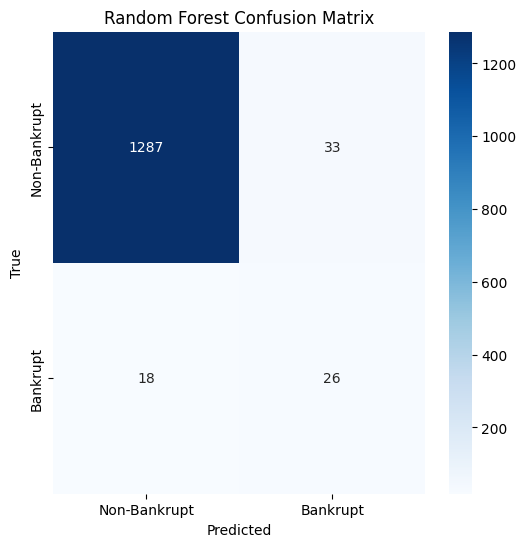

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1320
           1       0.42      0.50      0.46        44

    accuracy                           0.96      1364
   macro avg       0.70      0.74      0.72      1364
weighted avg       0.97      0.96      0.96      1364

XGBoost Confusion Matrix:
[[1290   30]
 [  22   22]]


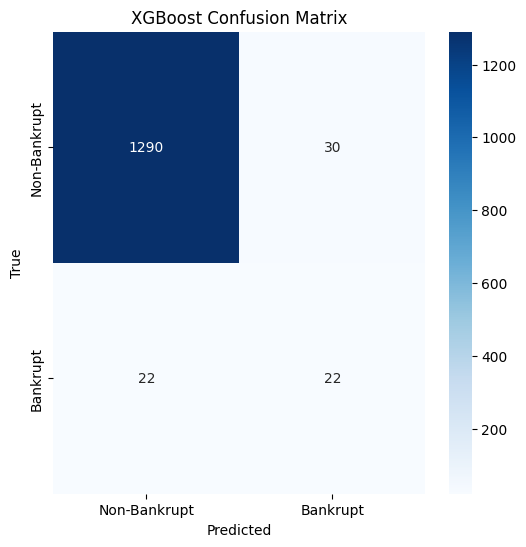

Random Forest with PCA Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.95      0.97      1320
           1       0.29      0.57      0.38        44

    accuracy                           0.94      1364
   macro avg       0.64      0.76      0.68      1364
weighted avg       0.96      0.94      0.95      1364

XGBoost with PCA Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.94      0.96      1320
           1       0.25      0.57      0.35        44

    accuracy                           0.93      1364
   macro avg       0.62      0.76      0.66      1364
weighted avg       0.96      0.93      0.94      1364



In [ ]:
# Features and target
X = df.drop('Bankrupt?', axis=1)  # Features
y = df['Bankrupt?']  # Target (Bankrupt: 0 or 1)

# Replace infinite values with NaN
X.replace([np.inf, -np.inf], np.nan, inplace=True)

# Alternatively, handle excessively large values by replacing values greater than a threshold (e.g., 1e10) with NaN
X[X > 1e10] = np.nan
X[X < -1e10] = np.nan

# Impute missing values with the median
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)  # Apply to features (X)

# Confirm no missing values after imputation
assert np.all(np.isfinite(X_imputed)), "There are still NaN values in the dataset after imputation!"

# Proceed with your pipeline using the imputed dataset
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42, stratify=y)

# Apply SMOTE to oversample the minority class in the training set
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Check class distribution before and after SMOTE
print("Before SMOTE - Train set class distribution:")
print(y_train.value_counts())
print("After SMOTE - Train set class distribution:")
print(pd.Series(y_train_res).value_counts())


# Train Random Forest and XGBoost on the resampled data
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_res, y_train_res)

xgb_model = XGBClassifier(random_state=42)
xgb_model.fit(X_train_res, y_train_res)

# Predictions with both models
y_pred_rf = rf_model.predict(X_test)
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate Random Forest
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))
print("Random Forest Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))

# Plot Random Forest Confusion Matrix
plt.figure(figsize=(6, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Bankrupt', 'Bankrupt'], yticklabels=['Non-Bankrupt', 'Bankrupt'])
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Evaluate XGBoost
print("XGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb))
print("XGBoost Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_xgb))

# Plot XGBoost Confusion Matrix
plt.figure(figsize=(6, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_xgb), annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Bankrupt', 'Bankrupt'], yticklabels=['Non-Bankrupt', 'Bankrupt'])
plt.title('XGBoost Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# PCA for dimensionality reduction
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)  # Use the imputed X

# Apply PCA (reduce to 10 principal components, or choose based on explained variance)
pca = PCA(n_components=10)
X_pca = pca.fit_transform(X_scaled)

# Split into train-test sets again with PCA data
X_train_pca, X_test_pca, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42, stratify=y)

# Apply SMOTE to the PCA-transformed data
X_train_res_pca, y_train_res_pca = smote.fit_resample(X_train_pca, y_train)

# Train Random Forest and XGBoost on PCA-transformed data
rf_model_pca = RandomForestClassifier(random_state=42)
rf_model_pca.fit(X_train_res_pca, y_train_res_pca)

xgb_model_pca = XGBClassifier(random_state=42)
xgb_model_pca.fit(X_train_res_pca, y_train_res_pca)

# Predictions with PCA-transformed data
y_pred_rf_pca = rf_model_pca.predict(X_test_pca)
y_pred_xgb_pca = xgb_model_pca.predict(X_test_pca)

# Evaluate Random Forest with PCA
print("Random Forest with PCA Classification Report:")
print(classification_report(y_test, y_pred_rf_pca))

# Evaluate XGBoost with PCA
print("XGBoost with PCA Classification Report:")
print(classification_report(y_test, y_pred_xgb_pca))

# Confusion matrix for PCA models
# Plotting can be done similarly to the previous plots

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      1320
           1       0.98      0.99      0.99      1320

    accuracy                           0.99      2640
   macro avg       0.99      0.99      0.99      2640
weighted avg       0.99      0.99      0.99      2640


Confusion Matrix:
[[1299   21]
 [   7 1313]]


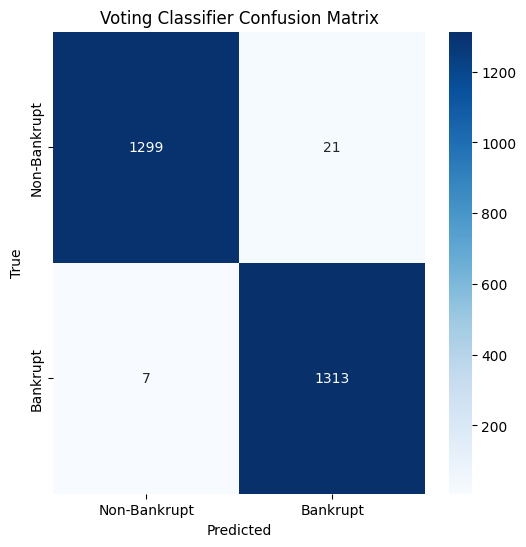

In [62]:
# Features and target
X = df.drop('Bankrupt?', axis=1)  # Features
y = df['Bankrupt?']  # Target (Bankrupt: 0 or 1)

# Handle missing values (in case it's not done yet)
X.replace([np.inf, -np.inf], np.nan, inplace=True)
X[X > 1e10] = np.nan
X[X < -1e10] = np.nan

# Impute missing values with the median
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)

# Apply SMOTE to oversample the minority class
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_imputed, y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42, stratify=y_res)

# Define models
rf_model = RandomForestClassifier(random_state=42)
xgb_model = XGBClassifier(random_state=42)

# Create a Voting Classifier to combine both models
voting_model = VotingClassifier(estimators=[
    ('rf', rf_model),
    ('xgb', xgb_model)
], voting='hard')  # 'hard' voting means majority class is predicted

# Create a pipeline that includes SMOTE, imputation, scaling, and the ensemble model
pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),  # Oversample the minority class
    ('scaler', StandardScaler()),      # Standardize features
    ('voting_model', voting_model)     # Use the voting model (ensemble)
])

# Train the pipeline with the training data
pipeline.fit(X_train, y_train)

# Make predictions with the trained pipeline
y_pred = pipeline.predict(X_test)

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Optionally: Plot confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Bankrupt', 'Bankrupt'], yticklabels=['Non-Bankrupt', 'Bankrupt'])
plt.title('Voting Classifier Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
